# 下载CIFAR数据集

In [1]:
import urllib.request
import os
import tarfile
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # CUP

#下载
url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
filepath = 'data/cifar-10-python.tar.gz'
if not os.path.isfile(filepath):
    result = urllib.request.urlretrieve(url,filepath)
    print('downloaded:',result)
else:
    print('Data file already exists.')
    
#解压
if not os.path.exists("data/cifar-10-batches-py"):
    tfile = tarfile.open("data/cifar-10-python.tar.gz",'r:gz')
    result = tfile.extractall('data/')
    print('Extracted to ./data/cifar-10-batches-py/')
else:
    print('Directory already exists')

Data file already exists.
Directory already exists


# 导入CIFAR数据集

In [2]:
import os 
import numpy as np
import pickle as p 

def load_CIFAR_batch(filename):
    """load single batch of CIFAR"""
    with open (filename,'rb')as f:
        #一个样本由标签和图像数据组成
        #<1 x label><3027 x pixel> (3027=32x32x3)
        #...
        #<1 x label><3027 x pixel>
        data_dict = p.load(f,encoding = 'bytes')
        images = data_dict[b'data']
        labels = data_dict[b'labels']
        
        #把原始数据结构调整为：BCWH
        images = images.reshape(10000,3,32,32)
        #tensorflow处理图像数据的结构：BWHC
        #把通道数据C移动到最后一个维度
        images = images.transpose(0,2,3,1)
        
        labels = np.array(labels)
        
        return images,labels

def load_CIFAR_data(data_dir):
    """load CIFAR data"""
    
    images_train = []
    labels_train = []
    for i in range (5):
        f = os.path.join(data_dir,'data_batch_%d'%(i+1))
        print('loading',f)
        #调用load_CIFAR_batch()获得批量的图像及其对应标签
        image_batch,label_batch = load_CIFAR_batch(f)
        images_train.append(image_batch)
        labels_train.append(label_batch)
        Xtrain = np.concatenate(images_train)
        Ytrain = np.concatenate(labels_train)
        del image_batch,label_batch
    Xtest,Ytest = load_CIFAR_batch(os.path.join(data_dir,'test_batch'))
    print('finished loadding CIFAR-10 data')
    
    #返回训练集的图像和标签，测试集的图像和标签
    return Xtrain,Ytrain,Xtest,Ytest

data_dir = 'data/cifar-10-batches-py/'
Xtrain,Ytrain,Xtest,Ytest = load_CIFAR_data(data_dir)
    

loading data/cifar-10-batches-py/data_batch_1
loading data/cifar-10-batches-py/data_batch_2
loading data/cifar-10-batches-py/data_batch_3
loading data/cifar-10-batches-py/data_batch_4
loading data/cifar-10-batches-py/data_batch_5
finished loadding CIFAR-10 data


# 图像数据预处理

In [3]:
#将图像进行数字标准化
Xtrain_normalize = Xtrain.astype('float32')/255.0
Xtest_normalize = Xtest.astype('float32')/255.0

#标签数据预处理
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
yy = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]]
encoder.fit(yy)
Ytrain_reshape = Ytrain.reshape(-1,1)
Ytrain_onehot = encoder.transform(Ytrain_reshape)
Ytest_reshape = Ytest.reshape(-1,1)
Ytest_onehot = encoder.transform(Ytest_reshape)

/Users/lumin/Library/Python/3.7/lib/python/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


# 定义共享函数

In [4]:
import tensorflow as tf 
tf.reset_default_graph()

#定义权值
def weight(shape,w1):
    #在构建模型时，需要使用tf.Variable来创建一个变量
    #在训练时，这个变量不断更新
    #使用函数tf.truncated_normal(截断的正态分布)生成标准差为0.1的随机数来初始化权值
    var = tf.Variable(tf.truncated_normal(shape,stddev=0.1),name='W')
    if w1 is not None:
        weight_loss = tf.multiply(tf.nn.l2_loss(var),w1,name='weight_loss')
        tf.add_to_collection('losses',weight_loss)
    return var

#定义偏置
#初始化为0.1
def bias(shape):
    return tf.Variable(tf.constant(0.1,shape=shape),name='b')

#d定义卷积操作
#步长为1，padding为‘SAME’
def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')

#定义池化操作
#步长为2，即原尺寸的长和宽各除以2
def max_pool_2x2(x):
    #tf.nn.max_pool(value,ksize,strides,padding,name=None
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')


# 定义网络结构

In [5]:
#输入层
#32x32图像，通道为3（RGB）
with tf.name_scope('input_layer'):
    x = tf.placeholder('float',shape=[None,32,32,3],name='x')

    
#第一个卷积层
#输入通道：3，输出通道：32，卷积后图像尺寸不变，依然是32x32
with tf.name_scope('conv_1'):
    W1 = weight([3,3,3,32],w1=0.0)
    b1 = bias([32])
    conv_1 = conv2d(x,W1) + b1
    conv_1 = tf.nn.relu(conv_1)
#第一个池化层
#将32x32图像缩小为16x16，池化不改变通道数量，因此依然是32个
with tf.name_scope('pool_1'):
    pool_1 = max_pool_2x2(conv_1)
    
norm1 = tf.nn.lrn(pool_1,4,bias=1.0,alpha=0.001/9.0,beta=0.75)
        
#第二个卷积层
#输入通道：32，输出通道：64，卷积后图像尺寸不变，依然是16x16
with tf.name_scope('conv_2'):
    W2 = weight([3,3,32,64],w1=0.0)
    b2 = bias([64])
    conv_2 = conv2d(norm1,W2) + b2
    conv_2 = tf.nn.lrn(tf.nn.relu(conv_2),4,bias=1.0,alpha=0.001/9.0,beta=0.75)
#第二个池化层
#将16x16图像缩小为8x8，池化不改变通道数量，因此依然是64个
with tf.name_scope('pool_2'):
    pool_2 = max_pool_2x2(conv_2)
    
#第三个卷积层
#输入通道：64，输出通道：128，卷积后图像尺寸不变，依然是16x16
with tf.name_scope('conv_3'):
    W3 = weight([3,3,64,128],w1=0.0)
    b3 = bias([128])
    conv_3 = conv2d(pool_2,W3) + b3
    conv_3 = tf.nn.relu(conv_3)
#第三个池化层
#将8x8图像缩小为4x4，池化不改变通道数量，因此依然是128个
with tf.name_scope('pool_3'):
    pool_3 = max_pool_2x2(conv_3)
    
#全连接层
#将第二个池化层的128个4x4的图像转换为一维的向量，长度是128*4*4=2048
#128个神经元
with tf.name_scope('fc'):
    #全连接一层
    W4 = weight([2048,256],w1=0.004) #256个神经元
    b4 = bias([256])
    flat = tf.reshape(pool_3,[-1,2048])
    h1 = tf.nn.relu(tf.matmul(flat,W4)+b4)
    #全连接二层
    W5 = weight([256,128],w1=0.004) #128个神经元
    b5 =  bias([128])
    h2 = tf.nn.relu(tf.matmul(h1,W5)+b5)
    h_dropout = tf.nn.dropout(h2,keep_prob=0.8)
    
    
#输出层
#输出层共有10个神经元，对应到0-9这10个类别
with tf.name_scope('output_layer'):
    W6 = weight([128,10],w1=0.0)
    b6 = bias([10])
    pred = tf.matmul(h_dropout,W6)+b6

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# 构建模型

## 定义标签占位符

In [6]:
with tf.name_scope("labels"):
    #定义占位符
    y = tf.placeholder('float',shape=[None,10],name='label')

## 定义损失函数

In [7]:
with tf.name_scope("loss"):
    loss_mse = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred,labels=y))
    loss_function = loss_mse+tf.add_n(tf.get_collection('losses'))        

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## 设置训练参数

In [8]:
train_epoches = 10
batch_size = 50
total_batch = int(len(Xtrain)/batch_size)
learning_rate = 0.001
epoch_list = [];accuracy_list = [];loss_list = [] 
epoch =tf.Variable(0,name='epoch',trainable=False)

## 选择优化器

In [9]:
with tf.name_scope("optimizer"):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_function)   

## 定义准确率

In [10]:
with tf.name_scope("evaluation"):
    correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(pred,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))

## 开启会话

In [11]:
config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.3
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

init = tf.global_variables_initializer()
sess.run(init)

## 断点续训

In [12]:
import os

#设置检查点存储目录
ckpt_dir = './CIFAR10_log/'
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
    
#生成saver
saver = tf.train.Saver(max_to_keep=1)

#如果有检查文件，读取最新的检查点文件，恢复各种变量值
ckpt = tf.train.latest_checkpoint(ckpt_dir)
if ckpt != None:
    saver.restore(sess,ckpt) #加载所有的参数
    #从这里开始就可以直接使用模型进行预测，或者接着继续训练了
else:
    print("Training from scratch.")
    
#获取续训参数
start = sess.run(epoch)
print("Training starts from {} epoch.".format(start+1))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./CIFAR10_log/CIFAR10_cnn_model.cpkt-10
Training starts from 10 epoch.


## 迭代训练

In [13]:
# 记录训练开始的时间
from time import time
startTime = time()

def get_train_batch(number,batch_size):
    return Xtrain_normalize[number*batch_size:(number+1)*batch_size],\
           Ytrain_onehot[number*batch_size:(number+1)*batch_size]

for ep in range(start,train_epoches):
    for i in range(total_batch):
        batch_x,batch_y = get_train_batch(i,batch_size)
        sess.run(optimizer,feed_dict={x:batch_x,y:batch_y})
        if i % 100 == 0:
            print("Batch{}".format(i),"finised")
            
    loss,acc = sess.run([loss_function,accuracy],feed_dict={x:batch_x,y:batch_y})
    epoch_list.append(ep+1)
    loss_list.append(loss)
    accuracy_list.append(acc)
    print("Train epoch:","%02d" % (sess.run(epoch+1)),\
          "Loss:","{:.6f}".format(loss),\
          "Accuracy:","{:.4f}".format(acc))
    
    #保存检查点
    saver.save(sess,ckpt_dir+"CIFAR10_cnn_model.cpkt",global_step=ep+1)
    sess.run(epoch.assign(ep+1))
    
duration = time()-startTime
print("Train finished takes:",duration)

Batch0 finised
Batch100 finised
Batch200 finised
Batch300 finised
Batch400 finised
Batch500 finised
Batch600 finised
Batch700 finised
Batch800 finised
Batch900 finised
Train epoch: 10 Loss: 0.612981 Accuracy: 0.8200
Train finished takes: 55.41235613822937


## 可视化损失值、准确率

<function matplotlib.pyplot.show(*args, **kw)>

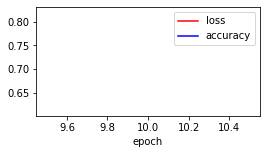

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

# 准确率、损失值可视化
fig = plt.gcf()
fig.set_size_inches(4,2)
plt.plot(epoch_list,loss_list,color = 'red',label = "loss")
plt.plot(epoch_list,accuracy_list,color = 'blue',label = 'accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show

# 模型评估及预测

## 计算测试集上个准确率

In [15]:
test_total_batch = int(len(Xtest_normalize)/batch_size)
test_acc_sum = 0.0
for i in range(test_total_batch):
    test_image_batch = Xtest_normalize[i*batch_size:(i+1)*batch_size]
    test_label_batch = Ytest_onehot[i*batch_size:(i+1)*batch_size]
    test_batch_acc = sess.run(accuracy,feed_dict={x:test_image_batch,y:test_label_batch})
    test_acc_sum +=test_batch_acc
test_acc = float(test_acc_sum/test_total_batch)
print("Test accuracy:{:.6f}".format(test_acc))

Test accuracy:0.720000


## 预测可视化

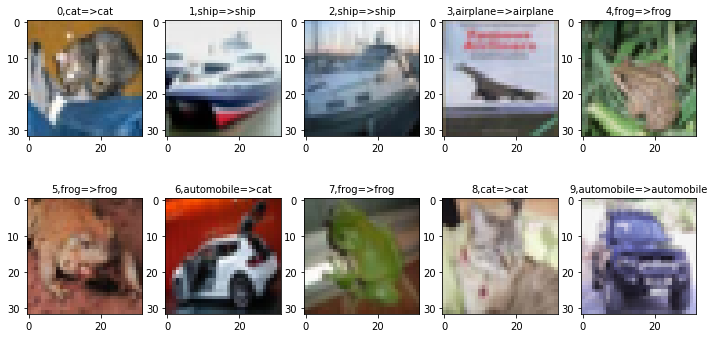

In [16]:
# 定义显示图像数据及其对应标签的函数
#定义标签字典，没一个数字所代表的图像类别的名称
label_dict = {0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",
              5:"dog",6:"frog",7:"horese",8:"ship",9:"trcuk"}

def plot_images_labels_prediction(images,labels,prediction,index,num=10):
    fig = plt.gcf()
    fig.set_size_inches(12,6)
    if num > 10:
        num = 10
    for i in range(0,num):
        ax = plt.subplot(2,5,1+i)#获取当前要处理的子图
        ax.imshow(images[index],cmap = 'binary') #显示第index个图像
        
        title = str(index)+','+label_dict[labels[index]]
        if len(prediction) > 0:
            title += '=>'+label_dict[prediction[index]]
            
        ax.set_title(title,fontsize = 10)
        
        index+=1
    plt.show()
    
    
#利用模型进行预测
prediction_result = sess.run(tf.argmax(pred,1),feed_dict={x:Xtest_normalize[:10]})

#可视化预测结果
plot_images_labels_prediction(Xtest,Ytest,prediction_result,0,10)